<a href="https://colab.research.google.com/github/Ernesto16/AI-Saturdays/blob/master/Week%207%20Assessment%3A%20Non-Linear%20Modeling/Week_7_Assessment_Non_Linear_Modeling_(Regression_problem).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Non-Linear Modeling
**We aim to:**

Build ML models using non-linear algorithms. (XGBoost, Decision Trees, Catboost, Random Forest)

Perform k-fold cross-validation

Perform hyperparameter tuning

Compare results and share how performance changed with each modification.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chitomuzokwe","key":"067decdd68ea9148a8068a44c3dfc9f4"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
mosapabdelghany/medical-insurance-cost-dataset                Medical Insurance Cost Dataset                          16425  2025-08-24 11:54:36.533000          20683        425  1.0              
saadaliyaseen/analyzing-student-academic-trends               Analyzing Student Academic Trends                        2430  2025-09-10 15:19:31.970000           6875        156  1.0              
minahilfatima12328/lifestyle-and-sleep-patterns               Lifestyle and Sleep Patterns                             2604  2025-09-18 14:30:08.190000

In [3]:
!kaggle datasets list -s Utrecht

ref                                                title                                       size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------  ------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ictinstitute/utrecht-housing-dataset               Utrecht housing dataset                    72621  2025-01-27 10:59:56.087000           1479          9  1.0              
ictinstitute/utrecht-fairness-recruitment-dataset  Utrecht Fairness Recruitment dataset       47198  2025-03-11 10:48:35.083000           1312          6  1.0              
tamal2000/utrecht-geolocations                     Utrecht Geolocations                      232161  2019-11-13 08:47:57.227000            100          2  0.88235295       
menglugeo/utrechtroads                             utrechtroads                              100470  2020-06-23 12:50:21.500000        

In [4]:
!kaggle datasets download ictinstitute/utrecht-housing-dataset

Dataset URL: https://www.kaggle.com/datasets/ictinstitute/utrecht-housing-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/70.9k [00:00<?, ?B/s]
100% 70.9k/70.9k [00:00<00:00, 261MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utrecht-housing-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import pandas as pd #import pandas libary

df = pd.read_csv('/content/utrechthousingsmall.csv') #read csv file
df.head(10) #view dataset

,id,zipcode,lot-len,lot-width,lot-area,house-area,garden-size,balcony,x-coor,y-coor,buildyear,bathrooms,taxvalue,retailvalue,energy-eff,monument,select
0,150219,3528,10.7,5.2,55.6,93.60,5.2,0,2068,5055,1935,1,419000,568000,0,1,0
1,880377,3800,18.6,6.2,115.3,111.60,40.9,2,2861,5056,1927,1,539000,649000,0,1,0
2,110456,3528,12.7,5.2,66.0,117.00,5.2,0,2267,5118,1941,1,521000,716000,0,1,0
3,520728,3800,16.2,6.3,102.1,141.75,26.5,2,2615,5150,1940,1,649000,825000,0,1,0
4,881551,3800,17.6,8.1,142.6,182.25,69.7,2,2756,5359,1960,1,843000,1015000,0,1,0
5,801846,3528,12.2,8.0,97.6,144.00,8.0,0,2219,5450,1961,2,654000,845000,1,0,0
6,892303,3800,15.0,10.9,163.5,196.20,54.5,2,2504,5559,1981,1,916000,1130000,0,1,0
7,342684,3525,14.0,11.0,154.0,148.50,22.0,2,2401,5667,1986,1,717000,883000,0,0,0
8,112919,3500,15.6,6.5,101.4,146.25,29.9,1,2558,5719,1991,1,666000,772000,0,0,0
9,263115,3500,15.6,10.3,160.7,185.40,68.0,2,2558,5762,1989,2,870000,1006000,1,0,0


In [7]:
!pip install xgboost --upgrade
!pip install catboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [9]:
# Cell 2: preprocessing
# Drop same columns as in your notebook:
df = df.drop(columns=["taxvalue", "energy-eff", "monument", "select"], errors='ignore')

# Drop id column
df = df.drop(columns=['id'], errors='ignore')

# Ensure zipcode is object/string
if 'zipcode' in df.columns:
    df['zipcode'] = df['zipcode'].astype(str)

# Drop other columns removed earlier (garden-size, lot-len, lot-width, x-coor, y-coor)
# Use errors='ignore' so this cell works even if some are already removed
df = df.drop(columns=["lot-len", "lot-width", "x-coor", "y-coor", "garden-size"], errors='ignore')

# Quick checks
print("Shape after drops:", df.shape)
print(df.info())

Shape after drops: (100, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   zipcode      100 non-null    object 
 1   lot-area     100 non-null    float64
 2   house-area   100 non-null    float64
 3   balcony      100 non-null    int64  
 4   buildyear    100 non-null    int64  
 5   bathrooms    100 non-null    int64  
 6   retailvalue  100 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 5.6+ KB
None


In [10]:
df

,zipcode,lot-area,house-area,balcony,buildyear,bathrooms,retailvalue
0,3528,55.6,93.60,0,1935,1,568000
1,3800,115.3,111.60,2,1927,1,649000
2,3528,66.0,117.00,0,1941,1,716000
3,3800,102.1,141.75,2,1940,1,825000
4,3800,142.6,182.25,2,1960,1,1015000
...,...,...,...,...,...,...,...
95,3525,119.9,153.00,1,2004,1,792000
96,3525,73.0,98.55,0,2007,1,497000
97,3528,90.3,154.80,2,1958,1,908000
98,3528,131.9,196.20,2,1956,1,1198000


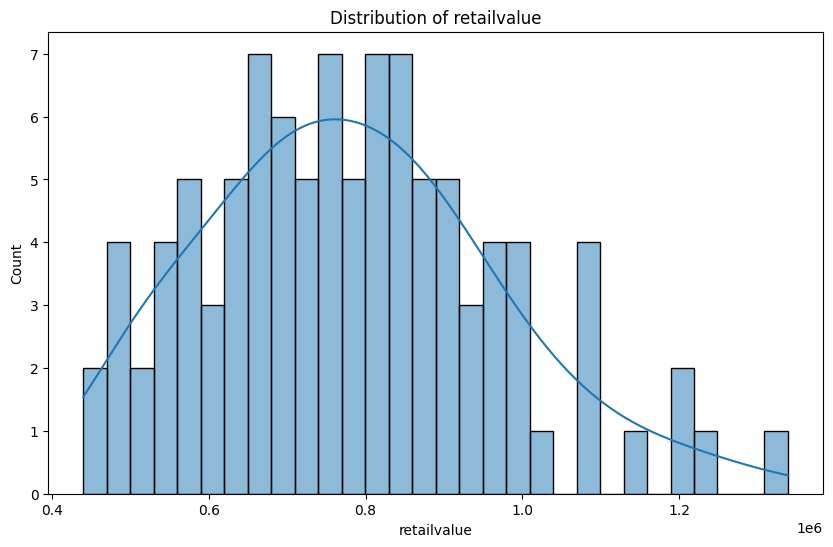

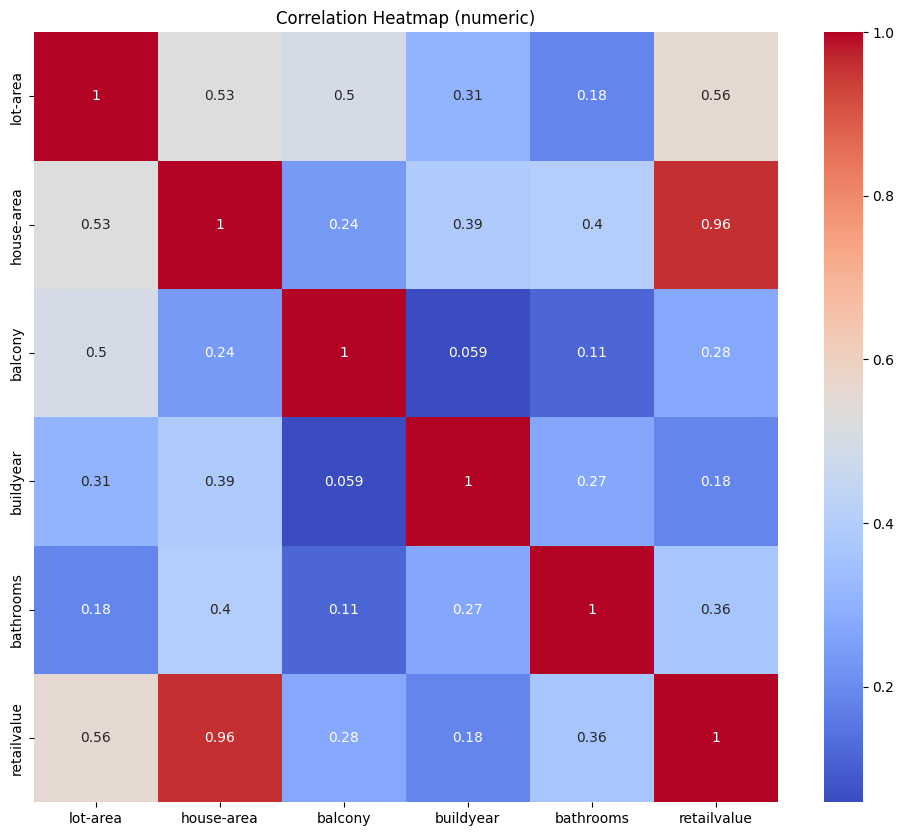

In [11]:
# Quick EDA visuals
plt.figure(figsize=(10,6))
sns.histplot(df["retailvalue"].dropna(), bins=30, kde=True)
plt.title("Distribution of retailvalue")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric)")
plt.show()

In [12]:
# Encoding and define X, y
# One-hot encode zipcode (drop_first=True to avoid multicollinearity)
df_enc = pd.get_dummies(df, columns=["zipcode"], drop_first=True)

# Define features and target
X = df_enc.drop("retailvalue", axis=1)
y = df_enc["retailvalue"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (100, 8)
y shape: (100,)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (80, 8) Test size: (20, 8)


In [14]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression baseline")
print("MSE:", mse_lr)
print("RMSE:", rmse_lr)
print("R2:", r2_lr)

Linear Regression baseline
MSE: 1229356729.9518209
RMSE: 35062.18375902763
R2: 0.9748229469053126


In [15]:
# train non-linear models and evaluate
models = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
models['Decision Tree'] = (dt, y_pred_dt)

# Random Forest (default)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
models['Random Forest'] = (rf, y_pred_rf)

# XGBoost
xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=1)  # set n_jobs=1 to avoid Colab GPU issues
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
models['XGBoost'] = (xgb, y_pred_xgb)

# CatBoost
cat = CatBoostRegressor(verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
models['CatBoost'] = (cat, y_pred_cat)

# Evaluate and collect metrics
results_list = []
for name, (m, y_pred) in models.items():
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results_list.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

# Add linear baseline
results_list.append({"Model":"Linear Regression", "MSE":mse_lr, "RMSE":rmse_lr, "R2":r2_lr})

results_df = pd.DataFrame(results_list).sort_values(by="R2", ascending=False).reset_index(drop=True)
results_df

,Model,MSE,RMSE,R2
0,Linear Regression,1.229357e+09,35062.183759,0.974823
1,CatBoost,2.965122e+09,54452.929618,0.939275
2,XGBoost,3.283746e+09,57303.981572,0.932749
3,Random Forest,3.649787e+09,60413.470394,0.925253
4,Decision Tree,6.632950e+09,81442.924800,0.864158


In [16]:
# k-fold CV (5 folds) — returns mean CV R2
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_summary = []
for name, (m, _) in models.items():
    try:
        scores = cross_val_score(m, X, y, cv=kf, scoring='r2', n_jobs=-1)
    except Exception as e:
        # some models (like CatBoost) may not accept n_jobs in cross_val_score; fallback to single-thread
        scores = cross_val_score(m, X, y, cv=kf, scoring='r2', n_jobs=1)
    cv_summary.append({"Model": name, "CV_R2_mean": np.mean(scores), "CV_R2_std": np.std(scores)})

cv_summary.append({"Model":"Linear Regression", "CV_R2_mean": np.mean(cross_val_score(LinearRegression(), X, y, cv=kf, scoring='r2')), "CV_R2_std": np.std(cross_val_score(LinearRegression(), X, y, cv=kf, scoring='r2'))})

cv_df = pd.DataFrame(cv_summary).sort_values(by="CV_R2_mean", ascending=False).reset_index(drop=True)
cv_df

,Model,CV_R2_mean,CV_R2_std
0,Linear Regression,0.970516,0.006769
1,CatBoost,0.931080,0.028577
2,Random Forest,0.929362,0.025048
3,XGBoost,0.924297,0.016908
4,Decision Tree,0.874471,0.042133


In [17]:
# GridSearchCV for Random Forest (regression)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params (RF):", grid.best_params_)
print("Best CV R2 (RF):", grid.best_score_)

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Test R2 with tuned RF:", r2_score(y_test, y_pred_best_rf))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R2 (RF): 0.9188637325790754
Test R2 with tuned RF: 0.9261738280042008


In [18]:
 # Merge test-set metrics and CV results
final_df = results_df.merge(cv_df, on="Model", how="left")
display(final_df)



,Model,MSE,RMSE,R2,CV_R2_mean,CV_R2_std
0,Linear Regression,1.229357e+09,35062.183759,0.974823,0.970516,0.006769
1,CatBoost,2.965122e+09,54452.929618,0.939275,0.931080,0.028577
2,XGBoost,3.283746e+09,57303.981572,0.932749,0.924297,0.016908
3,Random Forest,3.649787e+09,60413.470394,0.925253,0.929362,0.025048
4,Decision Tree,6.632950e+09,81442.924800,0.864158,0.874471,0.042133


From the results, the linear regression baseline actually performed best, achieving an
𝑅
2
 of 0.975 and an RMSE of about 35,062. This suggests that, for this dataset, the relationship between the predictors and the target variable (retail value) is largely linear and well-captured by the regression coefficients.

Among the non-linear models, performance was slightly lower overall. The Decision Tree Regressor had the weakest result (𝑅
2
=
0.864), reflecting its tendency to overfit and perform poorly on unseen data. The ensemble methods (Random Forest, XGBoost, and CatBoost) improved stability and generalization compared to a single tree, with
𝑅
2
 values between 0.925–0.94 and cross-validation scores that were fairly consistent.

Interestingly, even after hyperparameter tuning, the Random Forest only improved marginally (𝑅
2
=
0.926), still falling short of the linear model. This reinforces that the Utrecht housing dataset aligns more naturally with a linear relationship rather than requiring complex non-linear splits.

Overall, the comparison highlights that while non-linear models are powerful in capturing interactions and non-linearities, they do not always outperform linear models—especially when the underlying data structure is well-behaved and multicollinearity has been handled. The linear regression model proved both more accurate and more stable for this task.